<Time tt=[2458441.500800741 ... 2458448.5001062965] len=10080>


Text(0.5, 1.0, 'SO-50 elevation @ CN94\n2018-11-19T00:00:00Z to 2018-11-25T23:59:00Z')

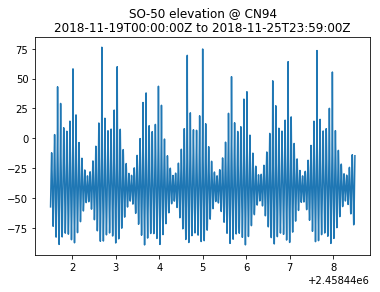

In [26]:
'''
2018-11-20
following along with <https://github.com/skyfielders/astronomy-notebooks/blob/master/Solvers/Earth-Satellite-Passes.ipynb>
'''

import math

from skyfield.api import load, Topos, earth, JulianDate
import matplotlib.pyplot as plt
from scipy import optimize
import maidenhead as mh
import numpy as np

ts = load.timescale()

tau = 2.0 * np.pi

'''CONFIGURE ME!!!!'''
tle = load.tle('data/tle/amateur.txt')
src_mh = 'CN94'
# do every minute for 24 hours starting on 2018-11-19 0000Z UTC
window_minutes = 24 * 60 * 7 # minutes for 7 days
time_range = ts.utc(2018, 11, 19, 0, range(window_minutes))

home = Topos(*mh.toLoc(src_mh))
satellite = 'SO-50'
#sat = tle['AO-92']
sat = tle[satellite]

diff = sat - home

def alt_f(t):
    return diff.at(t).altaz()[0].degrees

print(time_range)
altitudes = alt_f(time_range)
plt.plot(time_range.tai, altitudes)
plt.title('{} elevation @ {}\n{} to {}'.format(
        satellite
        , src_mh
        , time_range[0].utc_iso()
        , time_range[-1].utc_iso()
    )
)

In [51]:
# sample six points per orbit to improve performance
orbit_period_per_minute = tau / sat.model.no
orbit_period = orbit_period_per_minute / window_minutes
revolutions_in_window = 1.0 / orbit_period # approximate number of peaks
sample_points = revolutions_in_window * 6.0
sample_step = int(math.floor(window_minutes / sample_points))
print(revolutions_in_window, 'revolutions in window')
print(orbit_period_per_minute, 'orbital period per minute')
print(orbit_period / 6.0, 'orbit period')
print(sample_points, 'sample points (revs*6)')
sample_time_range = ts.utc(2018, 11, 19, 0, range(0, window_minutes, sample_step))
print(sample_time_range)

sample_altitudes = alt_f(sample_time_range)
for _ in sample_time_range:
    print(_.tai)

103.31574318531361 revolutions in window
97.56499531654028 orbital period per minute
0.0016131778326147533 orbit period
619.8944591118816 sample points (revs*6)
<Time tt=[2458441.500800741 ... 2458448.48968963] len=630>
2458441.5004282407
2458441.5115393517
2458441.522650463
2458441.533761574
2458441.5448726853
2458441.5559837963
2458441.5670949076
2458441.5782060185
2458441.5893171295
2458441.600428241
2458441.6115393518
2458441.622650463
2458441.633761574
2458441.644872685
2458441.6559837963
2458441.6670949073
2458441.6782060186
2458441.6893171296
2458441.700428241
2458441.711539352
2458441.7226504628
2458441.733761574
2458441.744872685
2458441.7559837964
2458441.7670949074
2458441.7782060187
2458441.7893171296
2458441.8004282406
2458441.811539352
2458441.822650463
2458441.8337615742
2458441.844872685
2458441.855983796
2458441.8670949074
2458441.8782060184
2458441.8893171297
2458441.9004282407
2458441.911539352
2458441.922650463
2458441.933761574
2458441.9448726852
2458441.955983796


103 sample peaks


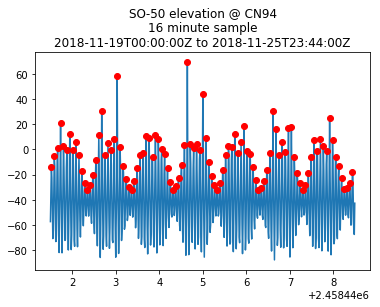

In [36]:
left_diff = np.ediff1d(sample_altitudes, to_begin=0.0)
right_diff = np.ediff1d(sample_altitudes, to_end=0.0)
maxima = (left_diff > 0.0) & (right_diff < 0.0)
print(sum(maxima), 'sample peaks')
plt.plot(sample_time_range.tai, sample_altitudes)
plt.title('{} elevation @ {}\n{} minute sample\n{} to {}'.format(
        satellite
        , src_mh
        , sample_step
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(sample_time_range[maxima].tai, sample_altitudes[maxima], 'ro')

<Time tt=[2458441.523022963 ... 2458448.434134074] len=103>


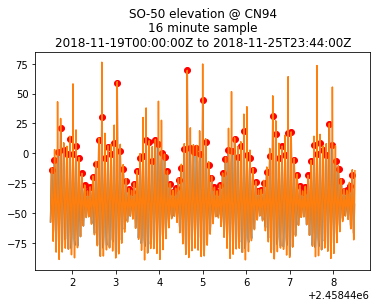

In [56]:
def alt_f_minimization_wrapper(t):
    return -alt_f(ts.tai_jd(t))

def find_highest(t, step):
    result = optimize.minimize_scalar(alt_f_minimization_wrapper, bracket=[t.tai + step, t.tai - step], tol=(1.0 / 24.0 / 60.0 / 60.0) / t.tai)
    return result.x

print(sample_time_range[maxima])
t_highest = ts.tai_jd([find_highest(ti, (window_minutes / sample_points) / (60 * 24)) for ti in sample_time_range[maxima]])
plt.plot(sample_time_range.tai, sample_altitudes)
plt.title('{} elevation @ {}\n{} minute sample\n{} to {}'.format(
        satellite
        , src_mh
        , sample_step
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(sample_time_range[maxima].tai, sample_altitudes[maxima], 'ro')

In [ ]:
plt.title('{} elevation @ {}\n{} to {}'.format(
        satellite
        , src_mh
        , sample_time_range[0].utc_iso()
        , sample_time_range[-1].utc_iso()
    )
)
plt.plot(time_range.tai, altitudes)
plt.plot([_.tai for _ in t_highest], alt_f(t_highest), 'go')